# Load Library & Preprocess Data

In [1]:
import random, os, math
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
TRAIN_ROOT_PATH = f'../../Datasets/mpii_human_pose_v1'
pd.set_option('display.max_columns', None)
df_ = pd.read_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/mpii_dataset.csv')
df_ = df_.iloc[:, 1:-3]
df_ = df_.iloc[:, [0, 13, 14, 5, 6, 3, 4, 1, 2, 7, 8, 9, 10, 11, 12,
                  15, 16, 17, 18, 19, 20, 27, 28, 29, 30, 31, 32, 25, 26, 23, 24, 21, 22]]
spine = (np.array(df_.iloc[:, [13, 14]]) +  np.array(df_.iloc[:, [15, 16]])) // 2
df_ = pd.concat([df_, pd.DataFrame(spine)], axis=1)
df = df_.iloc[:, [0, 13, 14, 5, 6, 3, 4, 1, 2, 7, 8, 9, 10, 11, 12, 33, 34,
                  15, 16, 17, 18, 19, 20, 27, 28, 29, 30, 31, 32, 25, 26, 23, 24, 21, 22]]
df.rename(columns={0:'spine_X', 1:'spine_Y'}, inplace=True)
df.iloc[:, 0] = TRAIN_ROOT_PATH + f'/images/' + df.iloc[:, 0]
df.head()

,NAME,l ankle_X,l ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,pelvis_X,pelvis_Y,r ankle_X,r ankle_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,spine_X,spine_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,r shoulder_X,r shoulder_Y,r elbow_X,r elbow_Y,r wrist_X,r wrist_Y,l wrist_X,l wrist_Y,l elbow_X,l elbow_Y,l shoulder_X,l shoulder_Y
0,../../Datasets/mpii_human_pose_v1/images/01560...,656,231,616,269,573,185,610,187,620,394,647,188,661,221,651,203,647,176,637.0201,189.8183,695.9799,108.1817,601,167,553,161,606,217,688,313,693,240,692,185
1,../../Datasets/mpii_human_pose_v1/images/01559...,-1,-1,-1,-1,806,543,763,568,-1,-1,720,593,-1,-1,341,144,683,290,682.0000,256.0000,676.0000,68.0000,647,281,555,410,563,296,545,466,711,516,719,299
2,../../Datasets/mpii_human_pose_v1/images/00580...,883,707,816,510,908,438,974,446,804,711,1040,454,906,528,934,480,985,253,982.7591,235.9694,962.2409,80.0306,902,253,798,340,869,214,1142,478,1167,353,1067,253
3,../../Datasets/mpii_human_pose_v1/images/08661...,331,455,305,375,201,340,248,341,301,461,294,342,335,370,305,359,279,263,277.0210,268.7786,305.9790,184.2214,244,261,260,335,328,354,362,346,327,320,314,264
4,../../Datasets/mpii_human_pose_v1/images/06011...,881,349,896,318,865,248,904,237,980,322,943,226,948,290,869,242,858,135,871.1877,180.4244,835.8123,58.5756,792,147,754,247,772,294,961,223,995,163,923,123


### Set Seed

In [3]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

### Hyperparameter, Config, Callback

In [4]:
### Multi GPU ###
strategy = tf.distribute.MirroredStrategy()
print("Number of device : {}".format(strategy.num_replicas_in_sync))

### config ###
y_col = ['l ankle_X', 'l ankle_Y', 'r knee_X', 'r knee_Y', 'r hip_X',
       'r hip_Y', 'pelvis_X', 'pelvis_Y', 'r ankle_X', 'r ankle_Y', 'l hip_X',
       'l hip_Y', 'l knee_X', 'l knee_Y', 'spine_X', 'spine_Y', 'thorax_X',
       'thorax_Y', 'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y',
       'r shoulder_X', 'r shoulder_Y', 'r elbow_X', 'r elbow_Y', 'r wrist_X',
       'r wrist_Y', 'l wrist_X', 'l wrist_Y', 'l elbow_X', 'l elbow_Y',
       'l shoulder_X', 'l shoulder_Y']

### Hyperparameter ###
EPOCH = 1000
initial_epoch = 0
learning_rate = 0.001
test_size = 0.3
target_size = (256, 256 ,3)
batch_size = 32
dropout_rate = 0.2

loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['mse']

patience = 10 # Early Stop patience

### Callback ###
# Tensorboard
logdir = os.path.join('logs', datetime.now().strftime(f'%Y%m%d-%H%M%S'))
tensorboard = tf.keras.callbacks.TensorBoard(
    logdir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
)

# Learningrate scheduler
def scheduler(epoch):
    if epoch < 10: return 0.001
    else: return 0.001 * math.exp(0.1 * (10 - epoch))
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

# Checkpoint
ckpt_dir = f'chechpoints'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    ckpt_dir,
    monitor='mse',
    verbose=1,
    save_best_only=True,
)

# Early stop
early_stop = tf.keras.callbacks.EarlyStopping('mse', patience=patience, verbose=1)

callbacks = [tensorboard, checkpoint, early_stop]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of device : 1


# DataGenerator

In [5]:
train_df, validation_df = train_test_split(df, test_size=test_size, random_state=SEED)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
)
validation_datagen = ImageDataGenerator(
    rescale=1./255.,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='NAME',
    y_col=y_col,
    target_size=target_size[:2],
    batch_size=batch_size,
    class_mode='multi_output',
    shuffle=True,

)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='NAME',
    y_col=y_col,
    traget_size=target_size[:2],
    batch_size=batch_size,
    class_mode='multi_output',
)

Found 12160 validated image filenames.
Found 5212 validated image filenames.


# Build Model

In [7]:
from tensorflow.keras.applications import ResNet50, resnet

In [8]:
class PoseNet:
    def __init__(self, target_size, dropout_rate, optimizer, loss_object, metrics):
        self.target_size = target_size
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.loss_object = loss_object
        self.metrics = metrics

    def createBaseModel(self):
        base_model = ResNet50(
            input_shape=self.target_size,
            include_top=False,
            weights='imagenet'
        )
        return base_model

    def createPreprocessInput(self):
        preprocess_input = resnet.preprocess_input
        return preprocess_input

    def __call__(self):
        base_model = self.createBaseModel()
        base_model.trainable = False
        preprocess_input = self.createPreprocessInput()

        inputs = tf.keras.Input(shape=self.target_size)
        x = preprocess_input(inputs)
        x = base_model(x, training=False)
        outputs = tf.keras.activations.sigmoid(x)

        model = tf.keras.Model(inputs, outputs)
        model.compile(
            optimizer=self.optimizer,
            loss=self.loss_object,
            metrics=self.metrics,
        )
        return model

In [9]:
# with strategy.scope():
with tf.device('/device:GPU:1'):
    model = PoseNet(target_size, dropout_rate, optimizer, loss_object, metrics)
    model = model()
    model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
tf_op_layer_Sigmoid (TensorF [(None, 8, 8, 2048)]      0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


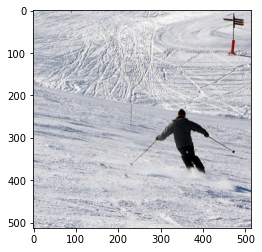

In [13]:
image = cv2.imread(f'../../Datasets/images/skiing.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.
plt.imshow(image)
plt.show()

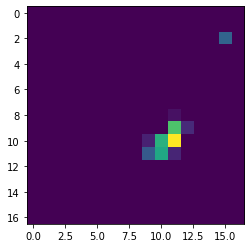

In [14]:
plt.imshow(model(image[tf.newaxis, ...])[0][:,:,1024])
plt.show()

In [17]:
model(image[tf.newaxis, ...])[0][:,:,1024].shape, image.shape

(TensorShape([17, 17]), (513, 513, 3))

In [10]:
loss, acc = model.evaluate(validation_generator)
print("initial loss: {:.2f}".format(loss))

In [11]:
history = model.fit(
    train_generator,
    batch_size=batch_size,
    epochs=EPOCH,
    callbacks=callbacks,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator) // 2,
    validation_steps=len(validation_generator) // 2,
)


Epoch 1/1000
190/190 [==============================] - ETA: 0s - loss: 198112.1250 - mse: 198112.1250  